# What's new in Qiskit 0.33 (Terra 0.19)?

**Note** This is a *tiny excerpt* of all the changes that might be particularly interesting for the application modules. All changes with detailed explanations can be found here: https://qiskit.org/documentation/release_notes.html#terra-0-19-0.

## Removal of Qiskit Aqua

Aqua is no longer included in the metapackage. That means `pip install qiskit` will not install Aqua (but not remove any exisiting installations).

## Optimizer signature

The Qiskit optimizers changed from
```
Optimizer.optimize(num_vars, objective_function, gradient_function, variable_bounds, initial_point) -> Tuple
```
to 
```
Optimizer.minimize(fun, x0, jac, bounds) -> OptimizerResult
```

In [27]:
import numpy as np
from qiskit.algorithms.optimizers import COBYLA

def f(x):
    return (np.linalg.norm(x) - 1) ** 2

initial_point = np.array([0.2, 1.5])
optimizer = COBYLA()

Before:

In [28]:
result = optimizer.optimize(len(initial_point), f, initial_point=initial_point)

print(type(result))
print(result)

<class 'tuple'>
(array([-0.73409049,  0.67888771]), 1.2391749693729586e-08, 35)


Now:

In [29]:
result = optimizer.minimize(f, initial_point)

print(type(result))
print(result)

<class 'qiskit.algorithms.optimizers.optimizer.OptimizerResult'>
{   'fun': 1.2391749693729586e-08,
    'jac': None,
    'nfev': 35,
    'nit': None,
    'njev': None,
    'x': array([-0.73409049,  0.67888771])}


## Dynamic circuits

We can now build circuits with classical control flow, such as for-loops and if-statements. They can be exported to OpenQASM3, but not yet executed within Qiskit.

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 1)

with qc.for_loop(range(5)) as i:
    qc.h(0)
    qc.cx(0, 1)
    qc.measure(0, 0)
    qc.break_loop().c_if(0, val=1)

In [4]:
qc.draw()

/Users/jul/Qiskit/qiskit-terra/qiskit/visualization/text.py:665: RuntimeWarning: The parameter "cregbundle" was disabled, since an instruction needs to refer to individual classical wires
  return "\n".join(self.lines()).encode(self.encoding).decode(self.encoding)


┌───────────┐
q_0: ┤0          ├
     │           │
q_1: ┤1 For_loop ├
     │           │
  c: ╡0          ╞
     └───────────┘

In [14]:
from qiskit.qasm3 import dumps

openqasm3 = dumps(qc)
print(openqasm3)

OPENQASM 3;
include "stdgates.inc";
bit[1] c;
qubit[2] _all_qubits;
let q = _all_qubits[0:1];
for _ in [0:4] {
  h q[0];
  cx q[0], q[1];
  c[0] = measure q[0];
  break;
}



### Two step transpilation

In variational algorithms: Transpile the parameterized circuit once *and* the bound circuit in each iteration.

```python
from qiskit.utils import QuantumInstance

unbound_pass_manager = # some general optimizations: gate commutativites, reduce 1q gates, ...
bound_pass_manager = # parameter-specific optimization: efficient pulse decompositions

quantum_instance = QuantumInstance(
    pass_manager=unbound_pass_manager,
    bound_pass_manager=bound_pass_manager,
    ...
)   
```

Example:

In [57]:
from qiskit.test.mock import FakeBelem
from qiskit.transpiler import PassManagerConfig
from qiskit.transpiler.preset_passmanagers import level_1_pass_manager

backend = FakeBelem()

unbound_pm = level_1_pass_manager(PassManagerConfig.from_backend(FakeBelem()))

In [61]:
from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary as std_eqlib
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
  Collect2qBlocks, ConsolidateBlocks, Optimize1qGatesDecomposition,
  RZXCalibrationBuilderNoEcho, UnrollCustomDefinitions, BasisTranslator
)
from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import EchoRZXWeylDecomposition

# Build the pass manager for the parameterized circuit
rzx_basis = ['rzx', 'rz', 'x', 'sx']

# Build a pass manager for the CX decomposition (works only on bound circuits)
bound_pm = PassManager([
  # Consolidate consecutive two-qubit operations.
  Collect2qBlocks(),
  ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rxx']),

  # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
  EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),

  # Attach scaled CR pulse schedules to the RZX gates.
  RZXCalibrationBuilderNoEcho(backend),

  # Simplify single-qubit gates.
  UnrollCustomDefinitions(std_eqlib, rzx_basis),
  BasisTranslator(std_eqlib, rzx_basis),
  Optimize1qGatesDecomposition(rzx_basis),
])

In [63]:
from qiskit.algorithms import VQE
from qiskit.opflow import Z
from qiskit.utils import QuantumInstance

quantum_instance = QuantumInstance(
    backend, pass_manager=unbound_pm, bound_pass_manager=bound_pm
)

vqe = VQE(quantum_instance=quantum_instance)
result = vqe.compute_minimum_eigenvalue(Z ^ Z)

### Pauli evolutions

The `PauliEvolutionGate` is a new gate for the time evolution (sums of) Paulis.

In [45]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.opflow import X, Z, I

op = 0.2 * (Z ^ Z) + (I ^ X) + (X ^ I)
time = 2

evo = PauliEvolutionGate(op, time)

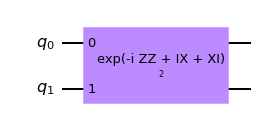

In [46]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)
circuit.append(evo, circuit.qubits)
circuit.draw('mpl')

Per default, a Lie-Trotter decomposition is used

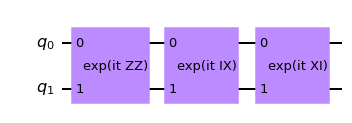

In [47]:
circuit.decompose().draw('mpl')

but by specifying the `synthesis` argument we can select the decomposition. For instance, we can use 4-th order Trotter decomposition with 2 repetitions.

In [48]:
from qiskit.synthesis import SuzukiTrotter

evo = PauliEvolutionGate(op, time, synthesis=SuzukiTrotter(order=4, reps=2))

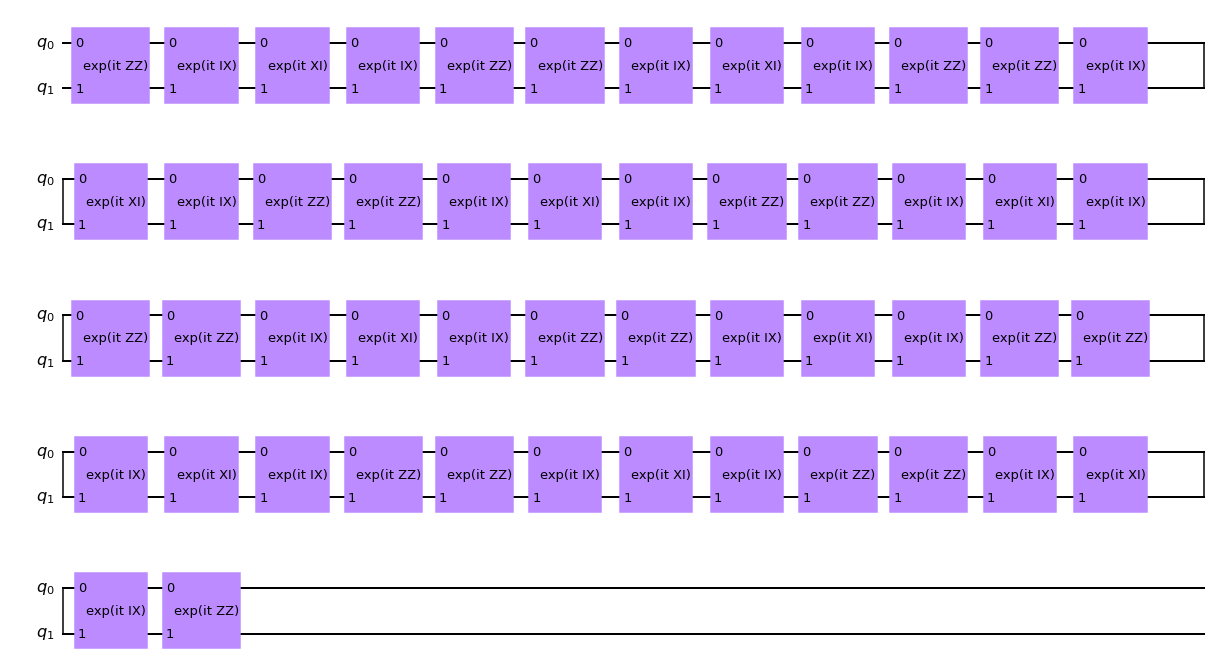

In [51]:
circuit = QuantumCircuit(2)
circuit.append(evo, circuit.qubits)
circuit.decompose().draw('mpl')

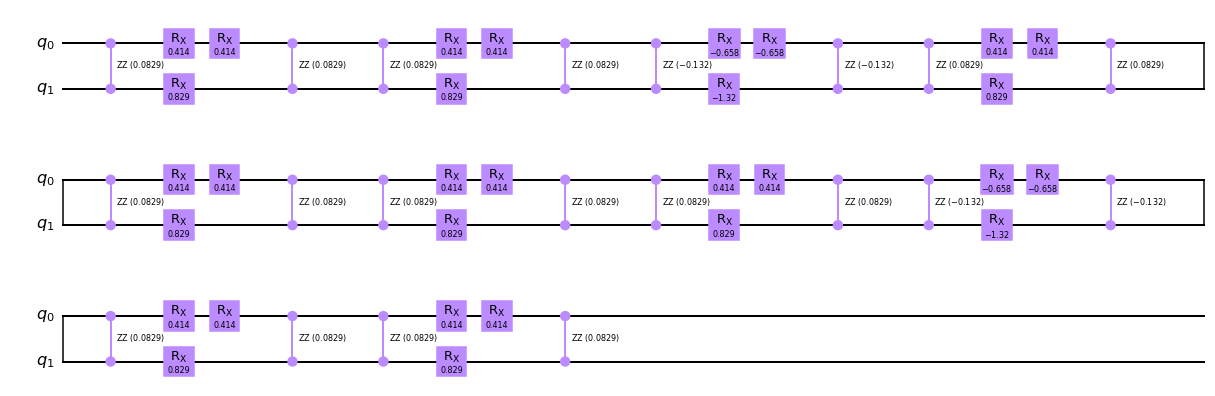

In [40]:
circuit.decompose().decompose().draw('mpl')